In [1]:
import imports

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns; 
sns.set(
    style="ticks", 
    color_codes=True, 
#    style="darkgrid"
)

from datasets import testloader
from initialisations import skmi2020 as skmi
from kmeans import distance_table
from metrics import accuracy
import nbutils

from sklearn.cluster import KMeans
import sklearn.metrics as skmetrics

%matplotlib inline

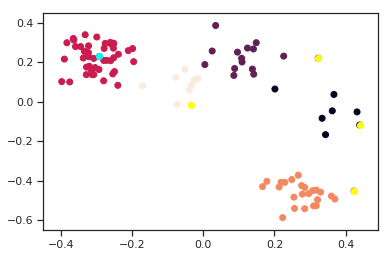

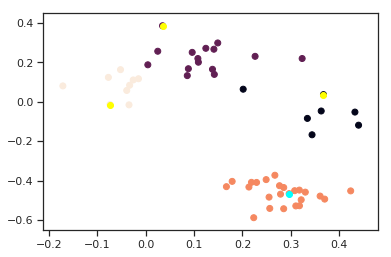

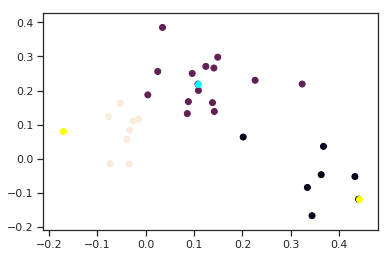

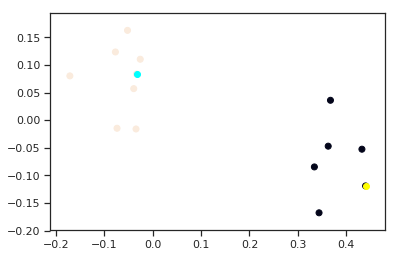

In [2]:
#dataset = testloader._load_local('5_2_1000_r_1.5_010')
dataset = testloader._load_local('skmi_test') # first 100 rows of the above dataset
K = 5 

#dataset = testloader.load_iris()
#K = 3

data = dataset.data
target = dataset.target

C = []


def calc_density(point, data):
    """Sum of distances to its nearest neighbours"""
        
    neighbours = int(len(data)/K) + 1
    dists = distance_table(np.array([point]), data)[0]
    idx = np.argpartition(dists, neighbours)
    subdists = dists[idx[:neighbours]]
    return np.sum(subdists)
    

def find_first_centroid(data):
    """The first promising point"""

    density = [calc_density(point, data) for point in data]    
    return data[np.argmin(density)]


def find_furthest(temp_centroids, data):
    """The furthest-nearest point (exact opposite of Yuan)"""
    distances = distance_table(data, temp_centroids)
    nearests = np.min(distances, axis=1)
    return data[np.argmax(nearests)]
    
    
to_find = K

while to_find > 1:

    first = find_first_centroid(data)
    C.append(first)

    my_c = target

    plt.scatter(data[:, 0], data[:, 1], c=my_c)
    plt.scatter(first[0], first[1], c='cyan')

    temp_centroids = np.array([first])

    while len(temp_centroids) < to_find:
        furthest = find_furthest(temp_centroids, data)
        plt.scatter(furthest[0], furthest[1], c='yellow')
        temp_centroids = np.vstack((temp_centroids, furthest))

    plt.show()
    #plt.clf()
    
    # Delete latest
    clustering = np.argmin(distance_table(temp_centroids, data), axis=0)
    mask = np.where(clustering==0)[0]
    data = np.delete(data, mask, axis=0)
    target = np.delete(target, mask, axis=0)
    
    to_find -= 1
    
    
# Finally just get the mean of the remaining points
final = np.mean(data, axis=0)

C.append(final)

### Initial centroids ie. before k-means

[[-0.29233074  0.22817392]
 [ 0.29651456 -0.46627294]
 [ 0.10791747  0.2190153 ]
 [-0.03310108  0.08351128]
 [ 0.38008301 -0.0725291 ]]


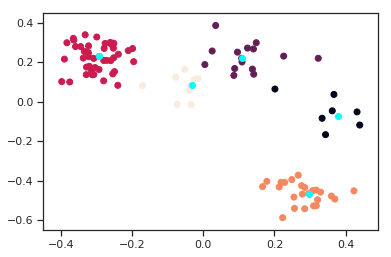

In [6]:
print(C)

data = dataset.data
my_c = dataset.target
plt.scatter(data[:, 0], data[:, 1], c=my_c)

for centroid in C:
    plt.scatter(centroid[0], centroid[1], c='cyan')

### After k-means

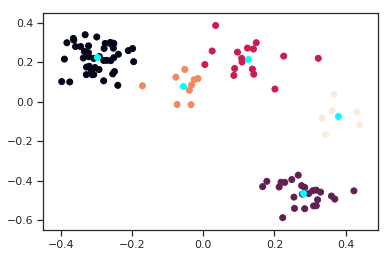

In [4]:
C = np.array(C)

est = KMeans(n_clusters=K, init=C, n_init=1)
est.fit(dataset.data)

data = dataset.data
my_c = est.labels_
plt.scatter(data[:, 0], data[:, 1], c=my_c)

for centroid in est.cluster_centers_:
    plt.scatter(centroid[0], centroid[1], c='cyan')

### Vs k-means++ (50 restarts)

In [5]:
ari_me = skmetrics.adjusted_rand_score(dataset.target, est.labels_)

est_kmpp = KMeans(n_clusters=K, n_init=50)
est_kmpp.fit(dataset.data)
ari_kmpp = skmetrics.adjusted_rand_score(dataset.target, est_kmpp.labels_)

print("ARI")
print("Me:", ari_me, "\tk-means++:", ari_kmpp)

print("INERTIA")
print("Me:", est.inertia_, "\tk-means++:", est_kmpp.inertia_)

ARI
Me: 0.9896851238946114 	k-means++: 0.9788526985387349
INERTIA
Me: 0.7287930368474844 	k-means++: 0.7267196862597944
